In [5]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae1 import *
from KDEs import *
from toolbox import *
import warnings
import itertools
import os
warnings.filterwarnings("ignore")

data = pd.read_csv('../data/btc future and reference rate/coingecko_future.csv')
data.head()
brr = data.loc[:,'log return bitcoin']
btc = data.loc[:,'log return future']
u = ECDF(brr)(brr)
v = ECDF(btc)(btc)
date_arr = []


In [63]:
G = Gumbel({'theta':10}, stats.uniform, stats.uniform)
Cl = Clayton({'theta':10}, stats.uniform, stats.uniform)

In [101]:
p = 0.1
def l_fn(theta_G, theta_S, u, v):
    G  = Gumbel({'theta':theta_G}, stats.norm, stats.norm)
    Cl = Clayton({'theta':theta_S}, stats.norm, stats.norm)
    l = 0.5*np.log(G.c(u,v)) + 0.5*np.log(Cl.c(u,v))
    if np.mean(np.isfinite(l)) >=1-2/len(u):
        return np.nanmean(l)
    else:
        return -5000

In [102]:
toopt = lambda theta: -l_fn(theta[0], theta[1], u,v)

In [106]:
theta = scipy.optimize.fmin(toopt, x0=(10,10), xtol=1e-10,
                    maxiter=50000,
                    maxfun=4000)
theta

Optimization terminated successfully.
         Current function value: -0.907281
         Iterations: 82
         Function evaluations: 179


array([4.14849912, 4.36113036])

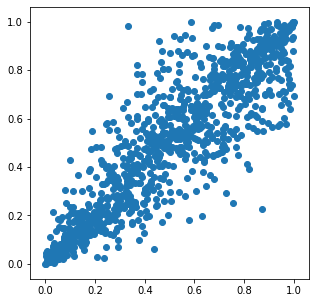

In [105]:
G = Gumbel({'theta':theta[0]}, stats.uniform, stats.uniform)
Cl = Clayton({'theta':theta[1]}, stats.uniform, stats.uniform)
s1 = Cl.sample(500)
s2 = G.sample(500)
plt.figure(figsize=(5,5))
# plt.scatter(s1[:,0],s1[:,1])
# plt.scatter(s2[:,0],s2[:,1])
s = np.concatenate((s1, s2), axis=0)
plt.scatter(s[:,0],s[:,1])

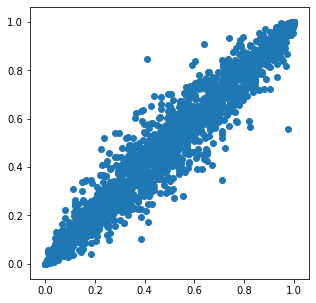

In [118]:
G1 = Gumbel({'theta':8}, stats.uniform, stats.uniform)
G2 = Gumbel({'theta':6}, stats.uniform, stats.uniform)
s1 = G1.sample(1000)
s2 = 1-G2.sample(1000)
plt.figure(figsize=(5,5))
s = np.concatenate((s1, s2), axis=0)
plt.scatter(s[:,0],s[:,1])

In [124]:
p = 0.1
def l_fn2(theta_1, theta_2, u, v):
    G1  = Gumbel({'theta':theta_1}, stats.norm, stats.norm)
    G2  = Gumbel({'theta':theta_2}, stats.norm, stats.norm)
    l = 0.5*np.log(G1.c(u,v)) + 0.5*np.log(G2.c(1-u,1-v))
    if np.mean(np.isfinite(l)) >=1-2/len(u):
        return np.nanmean(l)
    else:
        return -5000
    
theta = scipy.optimize.fmin(toopt, x0=(10,10), xtol=1e-10,
                    maxiter=50000,
                    maxfun=4000)
theta

Optimization terminated successfully.
         Current function value: -0.907281
         Iterations: 82
         Function evaluations: 179


array([4.14849912, 4.36113036])

In [107]:
q_arr = np.linspace(0.01,.99,50)
L_arr = []

for _ in range(2000):
    _id = np.random.choice(range(len(u)),len(u), True)
    _u = u[_id]
    _v = v[_id]
    L = np.array([empirical_lambda(_u,_v,q) for q in q_arr])
    L_arr.append(L)
    
L_arr = np.array(L_arr)

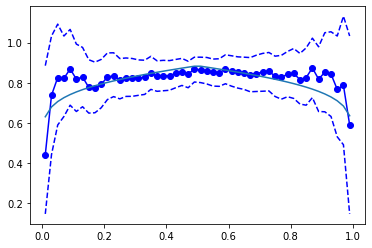

In [126]:
G1  = Gumbel({'theta':theta[0]}, stats.norm, stats.norm)
G2  = Gumbel({'theta':theta[1]}, stats.norm, stats.norm)

QD = [0.5*G1._lambda(q) + 0.5*G2._lambda(1-q) for q in q_arr]
LQ = np.quantile(np.array(L_arr), 0.05, axis=0)
UQ = np.quantile(np.array(L_arr), 0.95, axis=0)
plt.plot(q_arr, LQ , 'b--')
plt.plot(q_arr, np.quantile(np.array(L_arr), 0.5, axis=0), 'b-o')
plt.plot(q_arr, UQ, 'b--')
plt.plot(q_arr, QD)

In [131]:
s = G1.sample(10000)
stats.spearmanr(s[:,0], s[:,1])

SpearmanrResult(correlation=0.9172872001728719, pvalue=0.0)

In [132]:
stats.spearmanr(1-s[:,0], 1-s[:,1])

SpearmanrResult(correlation=0.9172872001728719, pvalue=0.0)

In [141]:
def mm_loss(theta, u, v, q_arr):
    G1  = Gumbel({'theta':theta[0]}, stats.norm, stats.norm)
    G2  = Gumbel({'theta':theta[1]}, stats.norm, stats.norm)
    
    m = np.array([stats.spearmanr(u, v)[0]] + [empirical_lambda(u, v, q) for q in q_arr]).reshape((1 + len(q_arr)))
    m_hat = np.array([G1.spearman_rho()/2+G2.spearman_rho()/2] + [G1._lambda(q)/2+G2._lambda(1-q)/2 for q in q_arr])
    g = m - m_hat
    return g.dot(g.T)

In [142]:
q_arr_opt = [0.05,0.1,0.9,0.95]
toopt = lambda theta: mm_loss(theta, u,v,q_arr_opt)

scipy.optimize.fmin(toopt, x0=(10,10))

AttributeError: 'Gumbel' object has no attribute 'spearman_rho'

Optimization terminated successfully.
         Current function value: -1.029223
         Iterations: 78
         Function evaluations: 164
Optimization terminated successfully.
         Current function value: 0.002953
         Iterations: 81
         Function evaluations: 168


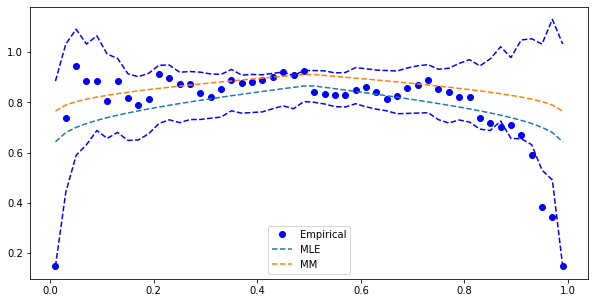

In [127]:
plt.figure(figsize=(10,5))
plt.plot(q_arr, L, 'bo', label='Empirical')

C = Gaussian_Mix_Independent({'rho':0.5, 'p':0.9}, stats.uniform, stats.uniform)

C.canonical_calibrate(u,v)
L_C = np.array([C._lambda(q) for q in q_arr])
L = np.array([empirical_lambda(u,v,q) for q in q_arr])

plt.plot(q_arr, L_C, '--', label="MLE")

C = Gaussian_Mix_Independent({'rho':0.5, 'p':0.9}, stats.uniform, stats.uniform)
C.mm_calibrate(u,v,[0.05,0.1,0.9,0.95])
L_C = np.array([C._lambda(q) for q in q_arr])
plt.plot(q_arr, L_C, '--', label="MM")
plt.plot(q_arr, np.quantile(np.array(L_arr), 0.05, axis=0), 'b--')
plt.plot(q_arr, np.quantile(np.array(L_arr), 0.95, axis=0), 'b--')
plt.legend()